<a id='intro'></a>
# **# AI SYSTEM FOR CALORIE ESTIMATION**

**The aim of the project**  is to create an AI-based system that can precisely estimate the number of calories in 
various kinds of food items.

The dataset that will be used is the **FoodData Central Dataset** by the U.S. DEPARTMENT OF AGRICULTURE, which contains about 36 files among which three will be used for the data analysis inorder to the predict the calories.

#**Importing Libraries:**

  The necessary libraries and tools to make the proposed system work are imported.. 
* Sklearn: provides a wide range of tools for supervised and unsupervised learning, as well as data preprocessing, model selection, and evaluation.
* Matplotlib: For creating plots and visualizations.
* Seaborn: Data visualization library for Python based on matplotlib
* urllib: module for downloading data from a given URL.
* numpy: For multi-dimensional arrays and mathematical functions.
* Matplotlib: For creating plots and visualizations.



In [1]:
# import the libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import urllib
from io import BytesIO
from zipfile import ZipFile

import requests
# for preprocessing data prior to model fitting
from sklearn import preprocessing
# for splitting datasets into training and test sets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
# performs cross-validation on a dataset
from sklearn.model_selection import cross_validate


import os
%matplotlib inline

The data zip file is directly downloaded from the link as it takes much time to attach locally. 
The datas of all the csv files are stored in a dictionary where key will be the file name and the value wil be the dataframe containing the data

In [2]:
food_data = {}

url_of_dataset = "https://fdc.nal.usda.gov/fdc-datasets/FoodData_Central_csv_2020-10-30.zip"
content = requests.get(url_of_dataset)
zf = ZipFile(BytesIO(content.content))
for item in zf.namelist():
  # checking if the file extension is ".csv"
  if ".csv" in item:
    fname = (item.split('.')[0]).split('/')[1]
    ext = item.split('.')[1]
    food_data[fname] = pd.read_csv(zf.open(item), low_memory=False, skiprows=0)


In [3]:
# Take an overview of the data files loaded
food_data.keys()

dict_keys(['acquisition_samples', 'agricultural_acquisition', 'all_downloaded_table_record_counts', 'branded_food', 'fndds_derivation', 'fndds_ingredient_nutrient_value', 'food', 'food_attribute', 'food_attribute_type', 'food_calorie_conversion_factor', 'food_category', 'food_component', 'food_nutrient', 'food_nutrient_conversion_factor', 'food_nutrient_derivation', 'food_nutrient_source', 'food_portion', 'food_protein_conversion_factor', 'food_update_log_entry', 'foundation_food', 'input_food', 'lab_method', 'lab_method_code', 'lab_method_nutrient', 'market_acquisition', 'measure_unit', 'nutrient', 'nutrient_incoming_name', 'retention_factor', 'sample_food', 'sr_legacy_food', 'sub_sample_food', 'sub_sample_result', 'survey_fndds_food', 'wweia_food_category'])

We are trying to find out the calories of the food items which are listed under the table "branded_food". Lets take a look at the table.

In [4]:
food_data['branded_food'].head()

fdc_id brand_owner        gtin_upc  \
0  344604    Red Gold  00072940755050   
1  344605    Red Gold  00072940755043   
2  344606     Cargill  00642205534517   
3  344607     Cargill  00642205510276   
4  344608     Cargill  00642205534500   

                                         ingredients  serving_size  \
0  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
1  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
2                    White Turkey, Natural Flavoring         112.0   
3                   Turkey Breast, Natural Flavoring         112.0   
4                         Turkey, natural Flavoring.         112.0   

  serving_size_unit household_serving_fulltext branded_food_category  \
0                 g                    1/2 cup                   NaN   
1                 g                    1/2 cup                   NaN   
2                 g                      4 oz.                   NaN   
3                 g                      4 oz.                   NaN   
4                 g                      4 oz.                   NaN   

  data_source modified_date available_date market_country  discontinued_date  
0        GDSN    2018-04-26     2019-04-01  United States                NaN  
1        GDSN    2018-04-26     2019-04-01  United States                NaN  
2        GDSN    2016-06-13     2019-04-01  United States                NaN  
3        GDSN    2016-06-07     2019-04-01  United States                NaN  
4        GDSN    2016-06-08     2019-04-01  United States                NaN

The nutrient content of the food is listed under another table named "nutrient".

In [5]:
food_data['nutrient'].head(3)


id               name unit_name  nutrient_nbr   rank
0  1002           Nitrogen         G         202.0  500.0
1  1003            Protein         G         203.0  600.0
2  1004  Total lipid (fat)         G         204.0  800.0

In [6]:
food_data['food_nutrient'].head()

id  fdc_id  nutrient_id  amount  data_points  derivation_id  min  \
0  13338591  323505         2048    35.0          NaN           49.0  NaN   
1  13338389  326196         2048    36.0          NaN           49.0  NaN   
2  13338390  747447         2048    32.0          NaN           49.0  NaN   
3  13338391  321611         2048    20.0          NaN           49.0  NaN   
4  13338392  746769         2048    17.0          NaN           49.0  NaN   

   max  median footnote  min_year_acquired  
0  NaN     NaN      NaN                NaN  
1  NaN     NaN      NaN                NaN  
2  NaN     NaN      NaN                NaN  
3  NaN     NaN      NaN                NaN  
4  NaN     NaN      NaN                NaN

In [7]:
# Function to remove the duplicates from the dataset and if number of nan values are more than threshold value we drop that column
def drop_duplicates_and_nan(data, threshold):
    data = data.drop_duplicates()
    
    for col in data.columns:
        sum_of_nan = data[col].isna().sum()
        if(sum_of_nan >= threshold):
            data = data.drop([col], axis=1)
    return data

The nutrient content of the food is listed under another table named "nutrient" and the table "food_nutrient" serves as a connection between the two table "branded_food" and "nutrient". Where it contains the columns "nutrient_id" and "fdc_id".Lets merge the three tables  to create one single dataframe for the ease of data processing.

In [8]:
food_data_merged = food_data['food_nutrient'].merge(food_data['nutrient'], left_on='nutrient_id', right_on='id', how='inner')
print(food_data_merged.shape)

food_data_merged = food_data_merged.merge(food_data['branded_food'], on='fdc_id', how='inner')
print(food_data_merged.shape)


(7547844, 16)
(6345119, 28)


In [9]:
# Summary of the DataFrame
food_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6345119 entries, 0 to 6345118
Data columns (total 28 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_x                        int64  
 1   fdc_id                      int64  
 2   nutrient_id                 int64  
 3   amount                      float64
 4   data_points                 float64
 5   derivation_id               float64
 6   min                         float64
 7   max                         float64
 8   median                      float64
 9   footnote                    object 
 10  min_year_acquired           float64
 11  id_y                        int64  
 12  name                        object 
 13  unit_name                   object 
 14  nutrient_nbr                float64
 15  rank                        float64
 16  brand_owner                 object 
 17  gtin_upc                    object 
 18  ingredients                 object 
 19  serving_size         

In [10]:
food_data_merged.describe()

id_x        fdc_id   nutrient_id        amount  data_points  \
count  6.345119e+06  6.345119e+06  6.345119e+06  6.345119e+06          0.0   
mean   6.892524e+06  6.357824e+05  1.172410e+03  1.616650e+03          NaN   
std    2.944118e+06  2.143422e+05  2.480475e+02  2.988401e+06          NaN   
min    2.877917e+06  3.446040e+05  1.003000e+03  0.000000e+00          NaN   
25%    4.464196e+06  4.609710e+05  1.008000e+03  0.000000e+00          NaN   
50%    6.050476e+06  5.788400e+05  1.092000e+03  4.600000e+00          NaN   
75%    9.668810e+06  7.939330e+05  1.253000e+03  4.400000e+01          NaN   
max    1.287522e+07  1.097509e+06  2.000000e+03  7.500000e+09          NaN   

       derivation_id  min  max  median  min_year_acquired          id_y  \
count   6.345119e+06  0.0  0.0     0.0                0.0  6.345119e+06   
mean    7.178298e+01  NaN  NaN     NaN                NaN  1.172410e+03   
std     2.439330e+00  NaN  NaN     NaN                NaN  2.480475e+02   
min     7.000000e+01  NaN  NaN     NaN                NaN  1.003000e+03   
25%     7.000000e+01  NaN  NaN     NaN                NaN  1.008000e+03   
50%     7.000000e+01  NaN  NaN     NaN                NaN  1.092000e+03   
75%     7.500000e+01  NaN  NaN     NaN                NaN  1.253000e+03   
max     7.900000e+01  NaN  NaN     NaN                NaN  2.000000e+03   

       nutrient_nbr          rank  serving_size  discontinued_date  
count  6.345119e+06  6.343469e+06  6.345119e+06                0.0  
mean   3.449853e+02  6.809819e+03  8.222656e+01                NaN  
std    1.483917e+02  3.876633e+04  8.828916e+01                NaN  
min    2.030000e+02  1.000000e+02  0.000000e+00                NaN  
25%    2.080000e+02  1.110000e+03  2.800000e+01                NaN  
50%    3.030000e+02  5.300000e+03  4.700000e+01                NaN  
75%    4.010000e+02  7.500000e+03  1.120000e+02                NaN  
max    8.510000e+02  9.999990e+05  9.979000e+03                NaN

We are removing duplicate rows and droping columns with over 50000 NaN values. After eliminating duplicates and nan values, the number of columns  fallen off to 20.


In [11]:
food_data_merged = drop_duplicates_and_nan(food_data_merged, 50000)
print(food_data_merged.shape)

(6345119, 20)


**Take an overview of   the data**

In [12]:
# Number of columns in the new dataset
food_data_merged.columns

Index(['id_x', 'fdc_id', 'nutrient_id', 'amount', 'derivation_id', 'id_y',
       'name', 'unit_name', 'nutrient_nbr', 'rank', 'brand_owner', 'gtin_upc',
       'ingredients', 'serving_size', 'serving_size_unit',
       'household_serving_fulltext', 'data_source', 'modified_date',
       'available_date', 'market_country'],
      dtype='object')

In [13]:
food_data_merged.head()

id_x  fdc_id  nutrient_id  amount  derivation_id  id_y  \
0  2878267  349386         1003     0.0           75.0  1003   
1  2878268  349386         1079     0.0           75.0  1079   
2  2878270  349386         1089     0.0           75.0  1089   
3  6281983  349386         1093   800.0           71.0  1093   
4  2878273  349386         1253     0.0           75.0  1253   

                   name unit_name  nutrient_nbr     rank brand_owner  \
0               Protein         G         203.0    600.0         NaN   
1  Fiber, total dietary         G         291.0   1200.0         NaN   
2              Iron, Fe        MG         303.0   5400.0         NaN   
3            Sodium, Na        MG         307.0   5800.0         NaN   
4           Cholesterol        MG         601.0  15700.0         NaN   

         gtin_upc                                        ingredients  \
0  00092325494046  WATER, EXPELLER-PRESSED CANOLA OIL, ORGANIC BA...   
1  00092325494046  WATER, EXPELLER-PRESSED CANOLA OIL, ORGANIC BA...   
2  00092325494046  WATER, EXPELLER-PRESSED CANOLA OIL, ORGANIC BA...   
3  00092325494046  WATER, EXPELLER-PRESSED CANOLA OIL, ORGANIC BA...   
4  00092325494046  WATER, EXPELLER-PRESSED CANOLA OIL, ORGANIC BA...   

   serving_size serving_size_unit household_serving_fulltext data_source  \
0          30.0                 g                     2 Tbsp        GDSN   
1          30.0                 g                     2 Tbsp        GDSN   
2          30.0                 g                     2 Tbsp        GDSN   
3          30.0                 g                     2 Tbsp        GDSN   
4          30.0                 g                     2 Tbsp        GDSN   

  modified_date available_date market_country  
0    2017-10-10     2019-04-01  United States  
1    2017-10-10     2019-04-01  United States  
2    2017-10-10     2019-04-01  United States  
3    2017-10-10     2019-04-01  United States  
4    2017-10-10     2019-04-01  United States

In [14]:
# Nutrient informations in the dataset
food_data_merged.name.unique()

array(['Protein', 'Fiber, total dietary', 'Iron, Fe', 'Sodium, Na',
       'Cholesterol', 'Fatty acids, total trans',
       'Fatty acids, total saturated', 'Total lipid (fat)',
       'Carbohydrate, by difference', 'Energy',
       'Sugars, total including NLEA', 'Calcium, Ca', 'Potassium, K',
       'Vitamin D (D2 + D3), International Units',
       'Vitamin C, total ascorbic acid', 'Vitamin A, IU', 'Magnesium, Mg',
       'Sorbitol', 'Riboflavin', 'Vitamin B-12', 'Niacin', 'Vitamin B-6',
       'Sugars, added', 'Fatty acids, total monounsaturated',
       'Fatty acids, total polyunsaturated', 'Thiamin', 'Fiber, soluble',
       'Pantothenic acid', 'Folate, total', 'Iodine, I', 'Xylitol',
       'Phosphorus, P', 'Zinc, Zn', 'Selenium, Se', 'Copper, Cu',
       'Manganese, Mn', 'Fructose', 'Total sugar alcohols',
       'Vitamin K (phylloquinone)', 'Carbohydrate, other', 'Ribose',
       'Folic acid', 'Chlorine, Cl', 'Vitamin E', 'Biotin', 'Ash',
       'Water', 'Vitamin E (label entr

In [15]:
# Unique units for the nutrient 'Energy' in the merged food data
food_data_merged[food_data_merged['name'] == 'Energy']['unit_name'].unique()

array(['KCAL', 'kJ'], dtype=object)

In [16]:
# count the number of occurrences of each unit_name for the name "Energy"
food_data_merged[food_data_merged['name'] == 'Energy'].groupby(['unit_name'])['unit_name'].count()

unit_name
KCAL    463464
kJ           9
Name: unit_name, dtype: int64

As we are find the calorie of the food,we are removing rows with energy values in kilojoules, and creating two dataframes X and y.The input data in X includes three columns, namely the fdc_id (a unique identifier for the food item), amount (the quantity of nutrient present in the food item), and name (the name of the nutrient). On the other hand, the output data in y represents information related to the Energy nutrient for each food item.

In [17]:
data_unit_kJ = food_data_merged[food_data_merged['unit_name']=='kJ']['fdc_id']

X = food_data_merged[(food_data_merged['name']!='Energy') & (~food_data_merged['fdc_id'].isin(data_unit_kJ))][['fdc_id', 'amount', 'name']].drop_duplicates()
y = food_data_merged[(food_data_merged['name']=='Energy') & (~food_data_merged['fdc_id'].isin(data_unit_kJ))][['fdc_id', 'amount', 'name']].drop_duplicates()

In [18]:
# sns.barplot(x='fdc_id',y='amount',data=df)

Created a new dataframe X with each unique combination of fdc_id and name as a new column and its corresponding amount value as the table entry.

In [19]:
X = pd.pivot_table(X, values=['amount'], index='fdc_id', columns='name')
X.head()

amount                                                              \
name     10:0 12:0 18:2 18:2 n-6 c,c 18:3 n-3 c,c,c (ALA) 8:0 Acetic acid   
fdc_id                                                                      
344604    NaN  NaN  NaN          NaN                  NaN NaN         NaN   
344605    NaN  NaN  NaN          NaN                  NaN NaN         NaN   
344606    NaN  NaN  NaN          NaN                  NaN NaN         NaN   
344607    NaN  NaN  NaN          NaN                  NaN NaN         NaN   
344608    NaN  NaN  NaN          NaN                  NaN NaN         NaN   

                                        ...  \
name   Alanine Alcohol, ethyl Arginine  ...   
fdc_id                                  ...   
344604     NaN            NaN      NaN  ...   
344605     NaN            NaN      NaN  ...   
344606     NaN            NaN      NaN  ...   
344607     NaN            NaN      NaN  ...   
344608     NaN            NaN      NaN  ...   

                                                                             \
name   Vitamin D (D2 + D3), International Units Vitamin D2 (ergocalciferol)   
fdc_id                                                                        
344604                                      0.0                         NaN   
344605                                      0.0                         NaN   
344606                                      NaN                         NaN   
344607                                      NaN                         NaN   
344608                                      NaN                         NaN   

                                                                            \
name   Vitamin D3 (cholecalciferol) Vitamin E Vitamin E (alpha-tocopherol)   
fdc_id                                                                       
344604                          NaN       NaN                          NaN   
344605                          NaN       NaN                          NaN   
344606                          NaN       NaN                          NaN   
344607                          NaN       NaN                          NaN   
344608                          NaN       NaN                          NaN   

                                                                          \
name   Vitamin E (label entry primarily) Vitamin K (phylloquinone) Water   
fdc_id                                                                     
344604                               NaN                       NaN   NaN   
344605                               NaN                       NaN   NaN   
344606                               NaN                       NaN   NaN   
344607                               NaN                       NaN   NaN   
344608                               NaN                       NaN   NaN   

                         
name   Xylitol Zinc, Zn  
fdc_id                   
344604     NaN      NaN  
344605     NaN      NaN  
344606     NaN      NaN  
344607     NaN      NaN  
344608     NaN      NaN  

[5 rows x 97 columns]

In [20]:
# Check the the number of NaN values in each column of the DataFrame X.
X.isna().sum()

        name                             
amount  10:0                                 483847
        12:0                                 483846
        18:2                                 483847
        18:2 n-6 c,c                         483847
        18:3 n-3 c,c,c (ALA)                 483847
                                              ...  
        Vitamin E (label entry primarily)    479625
        Vitamin K (phylloquinone)            480944
        Water                                480696
        Xylitol                              483764
        Zinc, Zn                             470504
Length: 97, dtype: int64

**Clean and prepare the X data for further analysis**



 Removing duplicate rows and droping columns with over 50000 NaN values of the X dataframe.

In [21]:
X = drop_duplicates_and_nan(X, 50000)
X.columns = [x[1] for x in X.columns]

X.head()

Carbohydrate, by difference  Fatty acids, total saturated  \
fdc_id                                                              
344604                         4.07                          0.00   
344605                         4.07                          0.00   
344606                         0.00                          0.89   
344607                         0.00                          0.89   
344608                         0.00                          4.46   

        Fatty acids, total trans  Fiber, total dietary  Protein  Sodium, Na  \
fdc_id                                                                        
344604                       0.0                   0.8     0.81       203.0   
344605                       0.0                   0.8     0.81       203.0   
344606                       0.0                   0.0    23.21        67.0   
344607                       NaN                   0.0    23.21        67.0   
344608                       NaN                   0.0    18.75       103.0   

        Sugars, total including NLEA  Total lipid (fat)  
fdc_id                                                   
344604                          2.44               0.41  
344605                          2.44               0.41  
344606                          0.00               2.68  
344607                           NaN               2.68  
344608                           NaN              15.18

Merging X and Y dataframes on the fdc_id column, maintaining only the rows with the same fdc_id in both dataframes. The resulting dataframe will include columns for each nutrient (from X) as well as a column for energy (from y).

In [22]:
X = X.merge(y[['fdc_id', 'amount']], on='fdc_id', how='inner')


update X where it fills all NaN values in the X dataframe with 0

In [23]:
X = X.fillna(0)
X.head()

fdc_id  Carbohydrate, by difference  Fatty acids, total saturated  \
0  344604                         4.07                           0.0   
1  344605                         4.07                           0.0   
2  344646                        87.80                           1.9   
3  344922                        16.90                           0.3   
4  345313                        88.00                           0.8   

   Fatty acids, total trans  Fiber, total dietary  Protein  Sodium, Na  \
0                       0.0                   0.8     0.81       203.0   
1                       0.0                   0.8     0.81       203.0   
2                       0.0                  10.9     5.20       522.0   
3                       0.1                   7.4    10.80       761.0   
4                       0.9                   4.9     6.00       153.0   

   Sugars, total including NLEA  Total lipid (fat)  amount  
0                          2.44               0.41    24.0  
1                          2.44               0.41    24.0  
2                         35.90               3.70   370.0  
3                          1.50               3.00   112.0  
4                         31.00               5.00   423.0

Using a boolean mask to pick just the rows and filters out rows from the X dataframe where the "amount" column is equal to 0.

In [24]:
X = X[X['amount']!=0]
X.head()

fdc_id  Carbohydrate, by difference  Fatty acids, total saturated  \
0  344604                         4.07                           0.0   
1  344605                         4.07                           0.0   
2  344646                        87.80                           1.9   
3  344922                        16.90                           0.3   
4  345313                        88.00                           0.8   

   Fatty acids, total trans  Fiber, total dietary  Protein  Sodium, Na  \
0                       0.0                   0.8     0.81       203.0   
1                       0.0                   0.8     0.81       203.0   
2                       0.0                  10.9     5.20       522.0   
3                       0.1                   7.4    10.80       761.0   
4                       0.9                   4.9     6.00       153.0   

   Sugars, total including NLEA  Total lipid (fat)  amount  
0                          2.44               0.41    24.0  
1                          2.44               0.41    24.0  
2                         35.90               3.70   370.0  
3                          1.50               3.00   112.0  
4                         31.00               5.00   423.0

## Eliminating outliers

In [25]:
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outlier detection
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# Create a mask for outliers
outlier_mask = (X < lower_bound) | (X > upper_bound)
# Remove rows containing at least one outlier
X = X[~outlier_mask.any(axis=1)]

print(X.shape)

(193347, 10)


Output variable y is created from the amount column of the dataframe X, and the the fdc_id and amount column is removed and the resulting dataframe is reassigned to X.

In [26]:
y = X['amount'].copy()
X = X[X.columns[~X.columns.isin(['fdc_id', 'amount'])]]

# Preprocessing

The columns with a variance greater than zero is only selected as they will not contribute much to the model

In [27]:
X = X[X.columns[(X.var(axis=0)>0).values]]
X.head(2)

Carbohydrate, by difference  Fatty acids, total saturated  \
0                         4.07                           0.0   
1                         4.07                           0.0   

   Fiber, total dietary  Protein  Sodium, Na  Sugars, total including NLEA  \
0                   0.8     0.81       203.0                          2.44   
1                   0.8     0.81       203.0                          2.44   

   Total lipid (fat)  
0               0.41  
1               0.41

<Axes: >

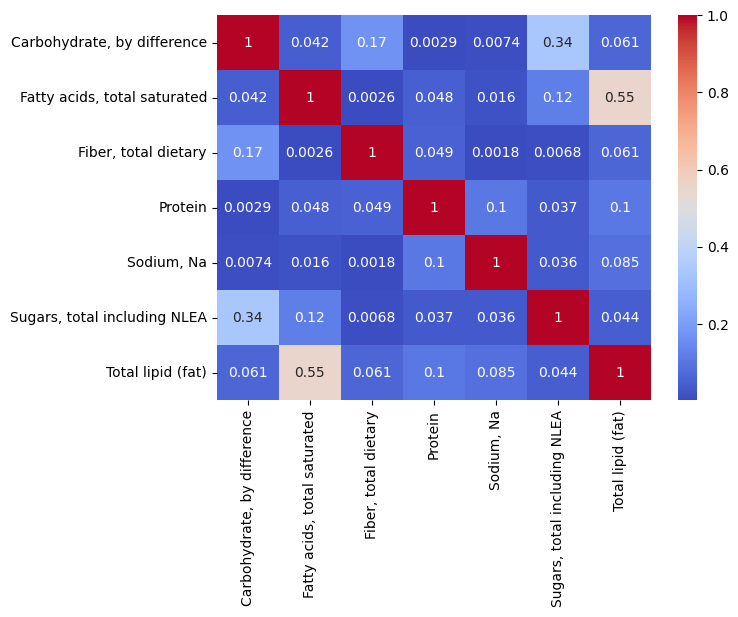

In [28]:
fig = plt.figure(figsize=(7,5))
x_corr = X.corr()**2
sns.heatmap(x_corr,annot=True, cmap='coolwarm')

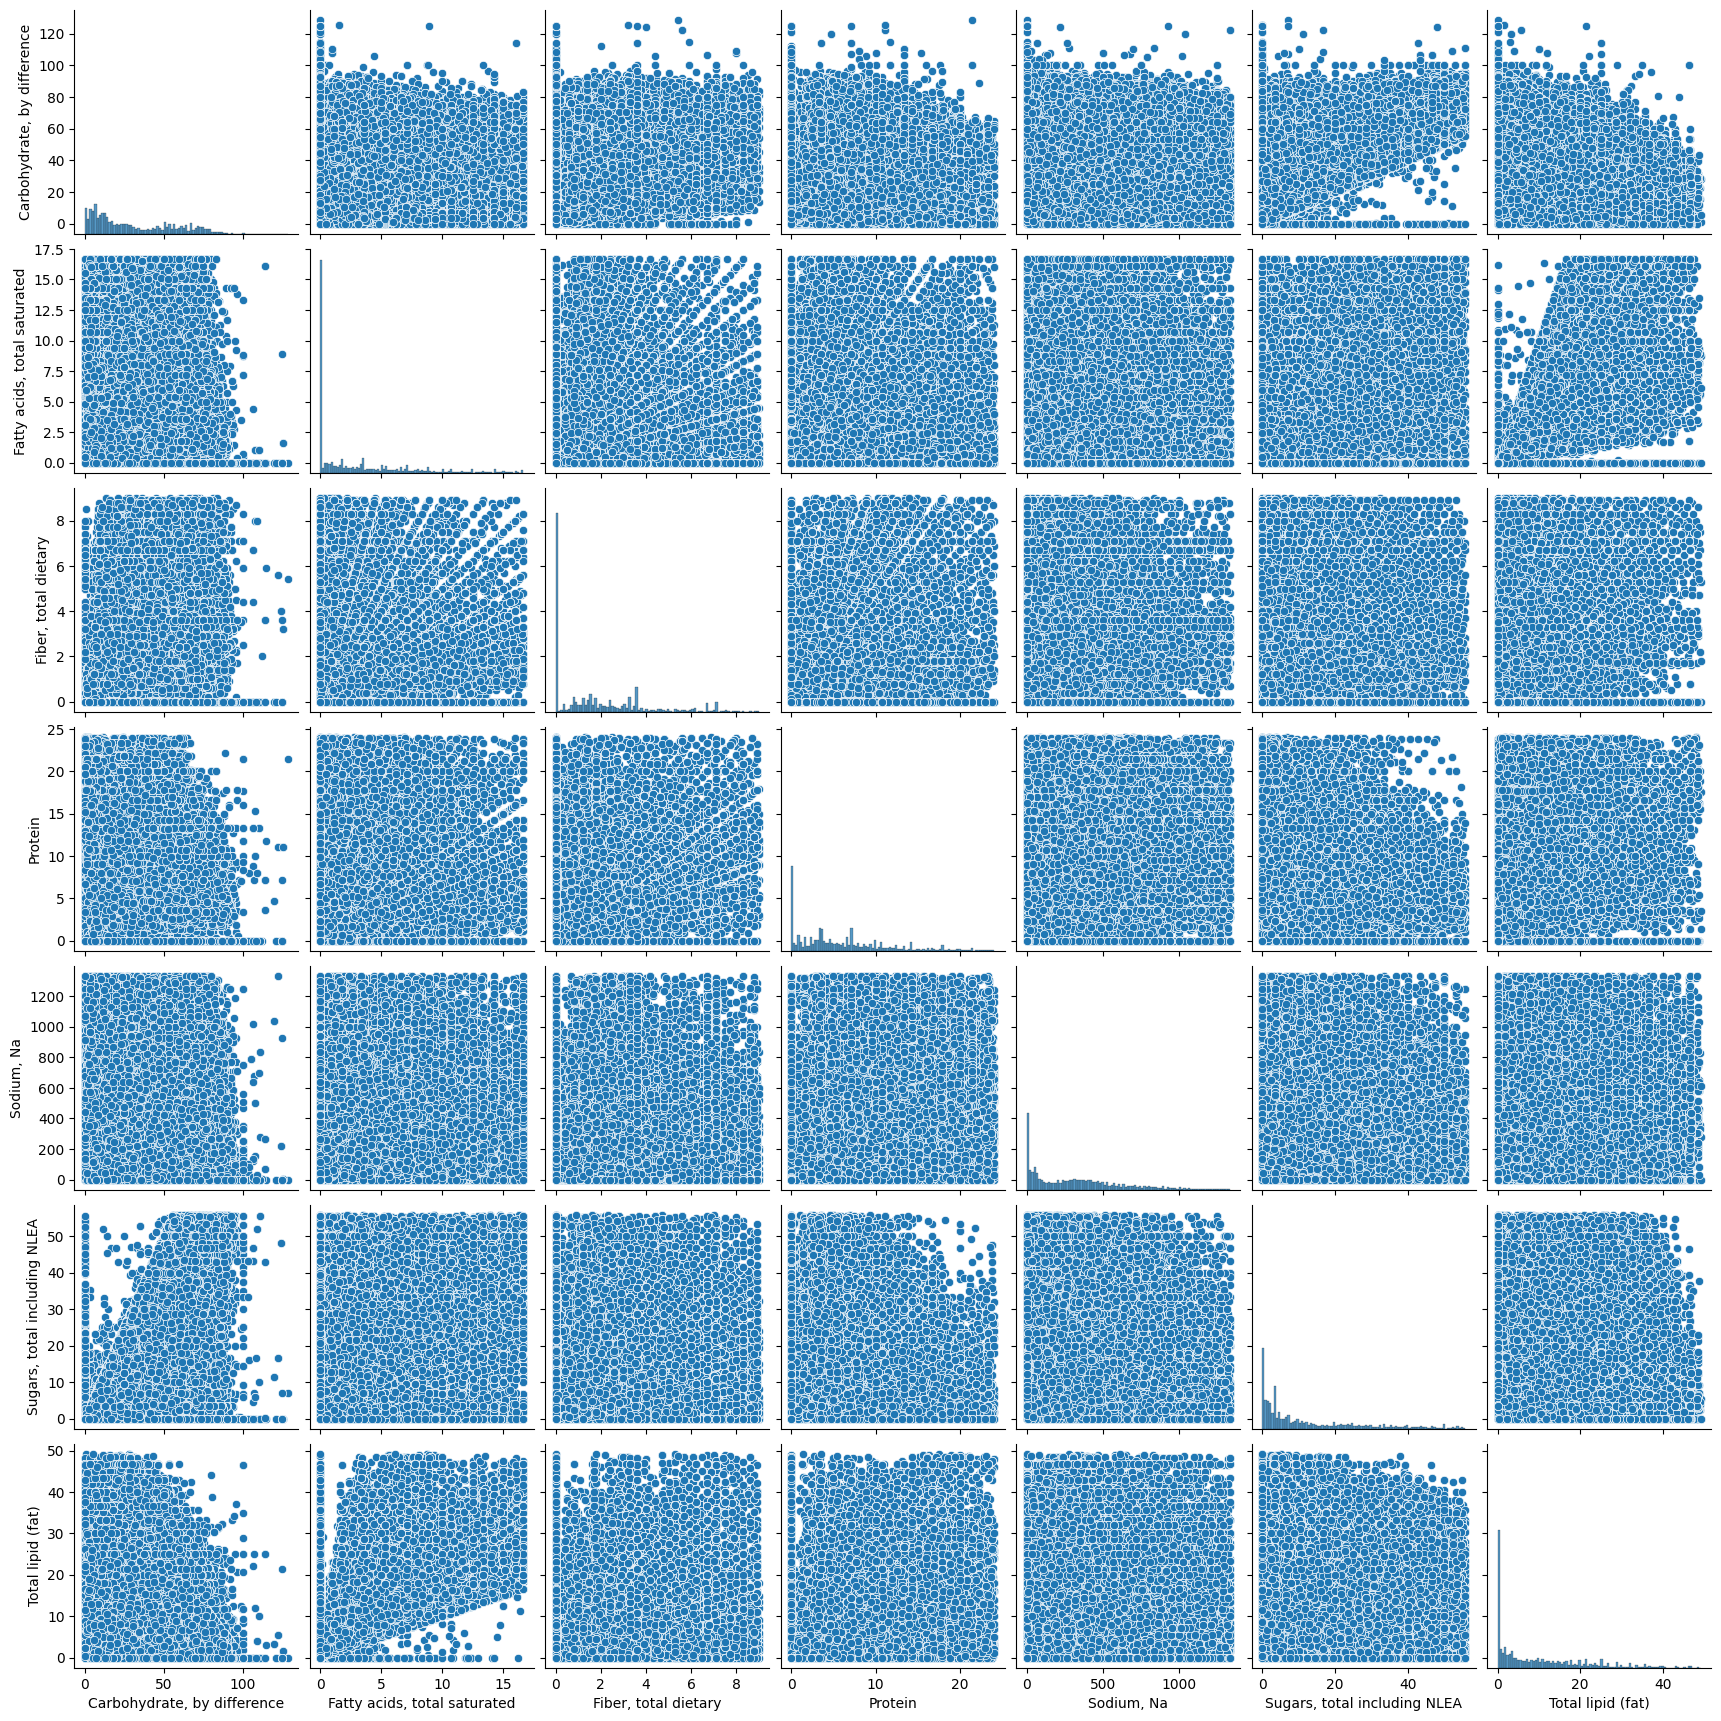

In [29]:
sns.pairplot(X)


**Standardizes the values in the X dataframe**, This is to prepare data for machine learning algorithms, as it can enhance performance and make it easier to compare different features. The fit() method is used to determine the mean and standard deviation of each column, and then the transform() method is used to apply the standardisation to the X dataframe.

In [30]:
std_scl = preprocessing.StandardScaler()
std_scl.fit(X)
X = std_scl.transform(X)

Split the X and y datasets into training and testing subsets, 30% of the data is used for testing, while the remaining 70% is used for training

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)
print(X_train.shape, X_test.shape)


(135342, 7) (58005, 7)


We are training the model using several regression algorithms such as LinearRegression, DecisionTreeRegressor, RandomForestRegressor, and KNeighborsRegressor. 
It then generates a list of these models and loops through them to 


*   Fit the model on the training data and make predictions on the testing data.
*   Computes the mean squared error (MSE) and R-squared values for each model.

*   Plots a scatter plot of actual versus predicted calories and a residual plot of actual vs predicted calories

The scatter plot illustrates how effectively the model predicts actual calories, and the residual plot displays the discrepancy between expected and actual values.

LinearRegression MSE: 503.179, R-squared: 0.980


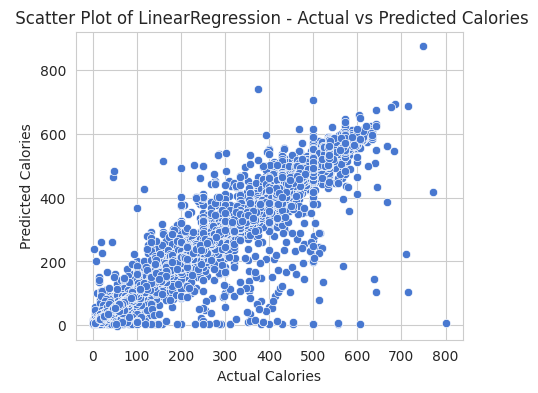

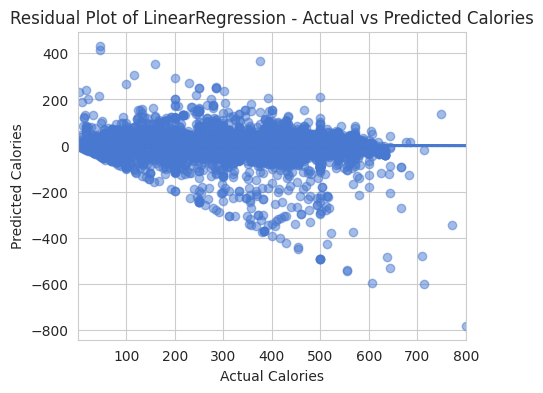

DecisionTreeRegressor MSE: 521.599, R-squared: 0.980


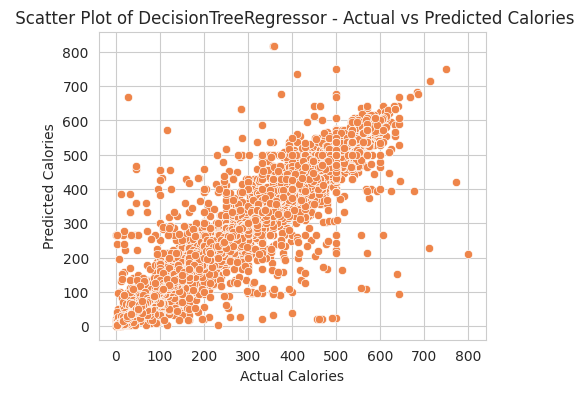

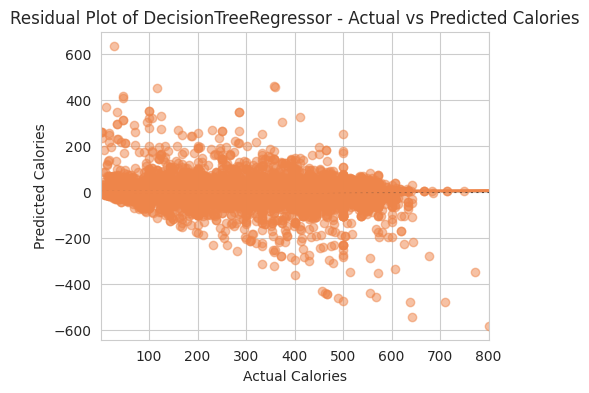

RandomForestRegressor MSE: 319.901, R-squared: 0.987


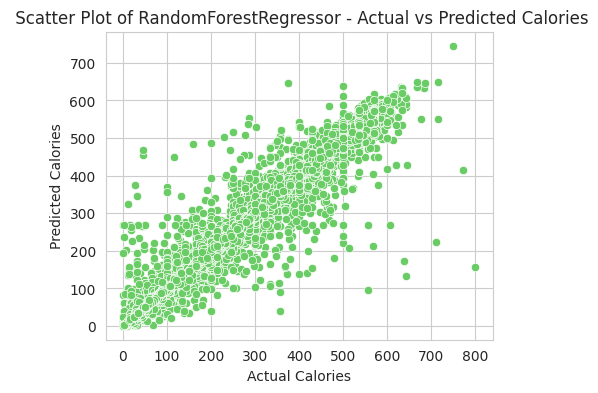

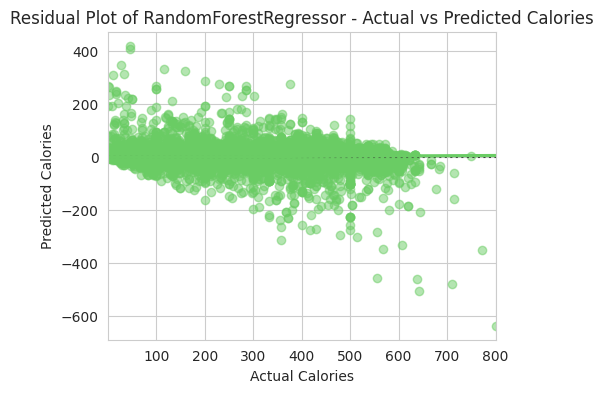

KNeighborsRegressor MSE: 445.501, R-squared: 0.983


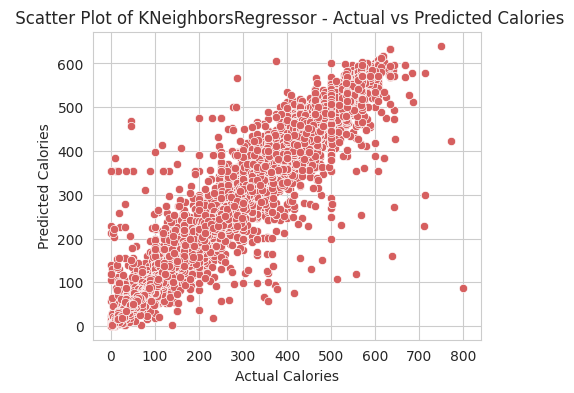

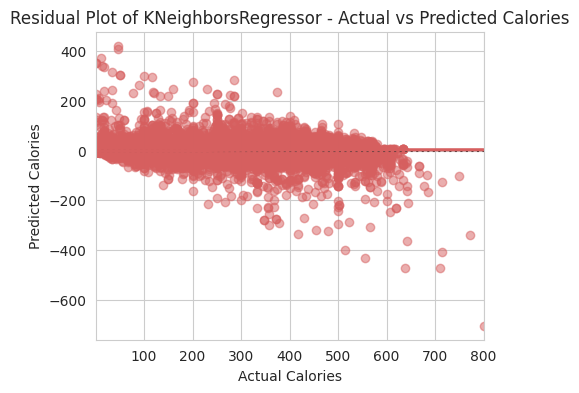

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

# # create a list of models
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor(n_neighbors=5)]
sns.set_style('whitegrid')
colors = sns.color_palette('muted', n_colors=len(models))


# # loop through models, fit on training data, and make predictions on testing data
for i,model in enumerate(models):  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r_squared = model.score(X_test, y_test)
    print(f'{model.__class__.__name__} MSE: {mse:.3f}, R-squared: {r_squared:.3f}')
    color = colors[i]
    plt.figure(figsize=(5, 4))
    sns.scatterplot(x=y_test, y=y_pred, color=color, legend=False)

    
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title(f" Scatter Plot of {type(model).__name__} - Actual vs Predicted Calories")
    plt.show()

    plt.figure(figsize=(5, 4))
    sns.residplot(x=y_test, y=y_pred, lowess=True, scatter_kws={'alpha': 0.5},color=color)
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title(f"Residual Plot of {type(model).__name__} - Actual vs Predicted Calories")
    plt.show()



To measure the accuracy, cross-validation is used, and the accuracy of all models is plotted in a bar graph for comparison.

<ipython-input-33-216042211ce7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_names, rotation=45)


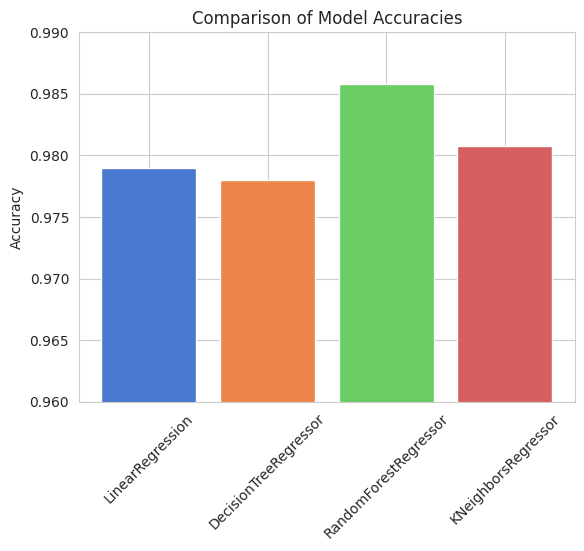

In [33]:
from sklearn.model_selection import cross_val_score

model_names = []
model_scores = []
for model in models:
    scores = cross_val_score(model,  X_train, y_train, cv=5)
    # print(f"Model: {model.__class__.__name__}")
    # print(f"MSE: {abs(scores.mean()):.2f}, R-squared: {scores[1]:.3f}")
    model_names.append(type(model).__name__)
    model_scores.append(scores.mean())
fig, ax = plt.subplots()
sns.set_style('whitegrid')
colors = sns.color_palette('muted', n_colors=len(models))
ax.bar(model_names, model_scores, color=colors)
ax.set_xticklabels(model_names, rotation=45)
ax.set_title('Comparison of Model Accuracies')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.96, 0.99)
plt.show()
